In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
import polars as pl
import pandas as pd
import plotly.graph_objects as go
import utm
import h3

repo_root = Path(os.getcwd()).parent

while not (repo_root / ".git").exists():
    repo_root = repo_root.parent

sys.path.append(str(repo_root))

# set the pandas plotting backend to plotly
pd.options.plotting.backend = "plotly"

## Load Radar Data


In [3]:
## Read in the Data
from src.filtering import Filtering
from src.lane_detection import LaneDetection


df = pl.scan_parquet(
    "/Users/max/Library/CloudStorage/Box-Box/Radar-Data/new_format/1678*.parquet",
    rechunk=True,
)

# create the file paths
network_outline_file = repo_root / "geo_data" / "network_outline.geojson"
radar_locations_file = repo_root / "geo_data" / "radar_origins.json"

In [4]:
f = Filtering(
    radar_location_path=radar_locations_file,
    network_boundary_path=network_outline_file,
)

interest_df = (
    df
    .filter(pl.col("epoch_time").dt.day() == 14)
    .pipe(f.create_object_id)
    .pipe(f.object_id_2_int)
    .pipe(f.crop_radius, radius=220)
    .pipe(f.crop_angle)
    # have to collect here because the next step involves am expensive operation
    .collect(streaming=True)
    .pipe(f.filter_short_trajectories, minimum_distance_m=50, minimum_duration_s=5)
)

function: object_id_2_int took: 7.009506225585938e-05 seconds
function: crop_radius took: 0.00017499923706054688 seconds
function: crop_angle took: 0.00036525726318359375 seconds
function: filter_short_trajectories took: 31.158775091171265 seconds


In [5]:
## Print the extent of data time
print(
    (
        (interest_df["epoch_time"].max() - interest_df["epoch_time"].min()).seconds
        / 60
        / 60
    ),
    "hours",
)

print(
    interest_df.shape[0] / 1e6,
)

23.99972222222222 hours
26.113582


In [6]:
interest_df['ip'].unique()

ip
str
"""10.160.7.137"""
"""10.160.7.142"""
"""10.160.7.146"""
"""10.160.7.147"""
"""10.160.7.141"""
"""10.160.7.136"""


## Create the Lane Detection Object

In [7]:
ld = LaneDetection(
    df=interest_df.filter(pl.col("ip") == "10.160.7.137"),
)

In [8]:
ld = ld.bin_data()

function: bin_data took: 1.1420512199401855 seconds


function: percentile_filter took: 0.1807878017425537 seconds


(<Figure size 640x480 with 1 Axes>, <Axes: >)

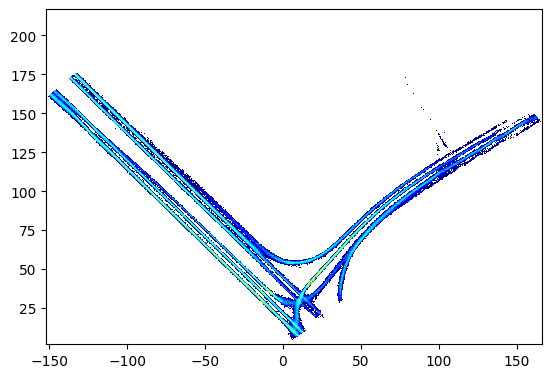

In [9]:
ld = ld.percentile_filter(40)

ld.plot_histogram("p_hist")

function: gaussian_filter took: 0.07177877426147461 seconds


(<Figure size 640x480 with 1 Axes>, <Axes: >)

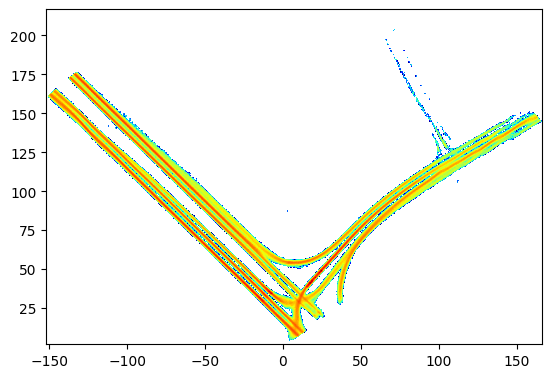

In [10]:
ld = ld.gaussian_filter(sigma=2)

ld.plot_histogram("p_hist_smooth")

function: find_peaks took: 0.19904518127441406 seconds


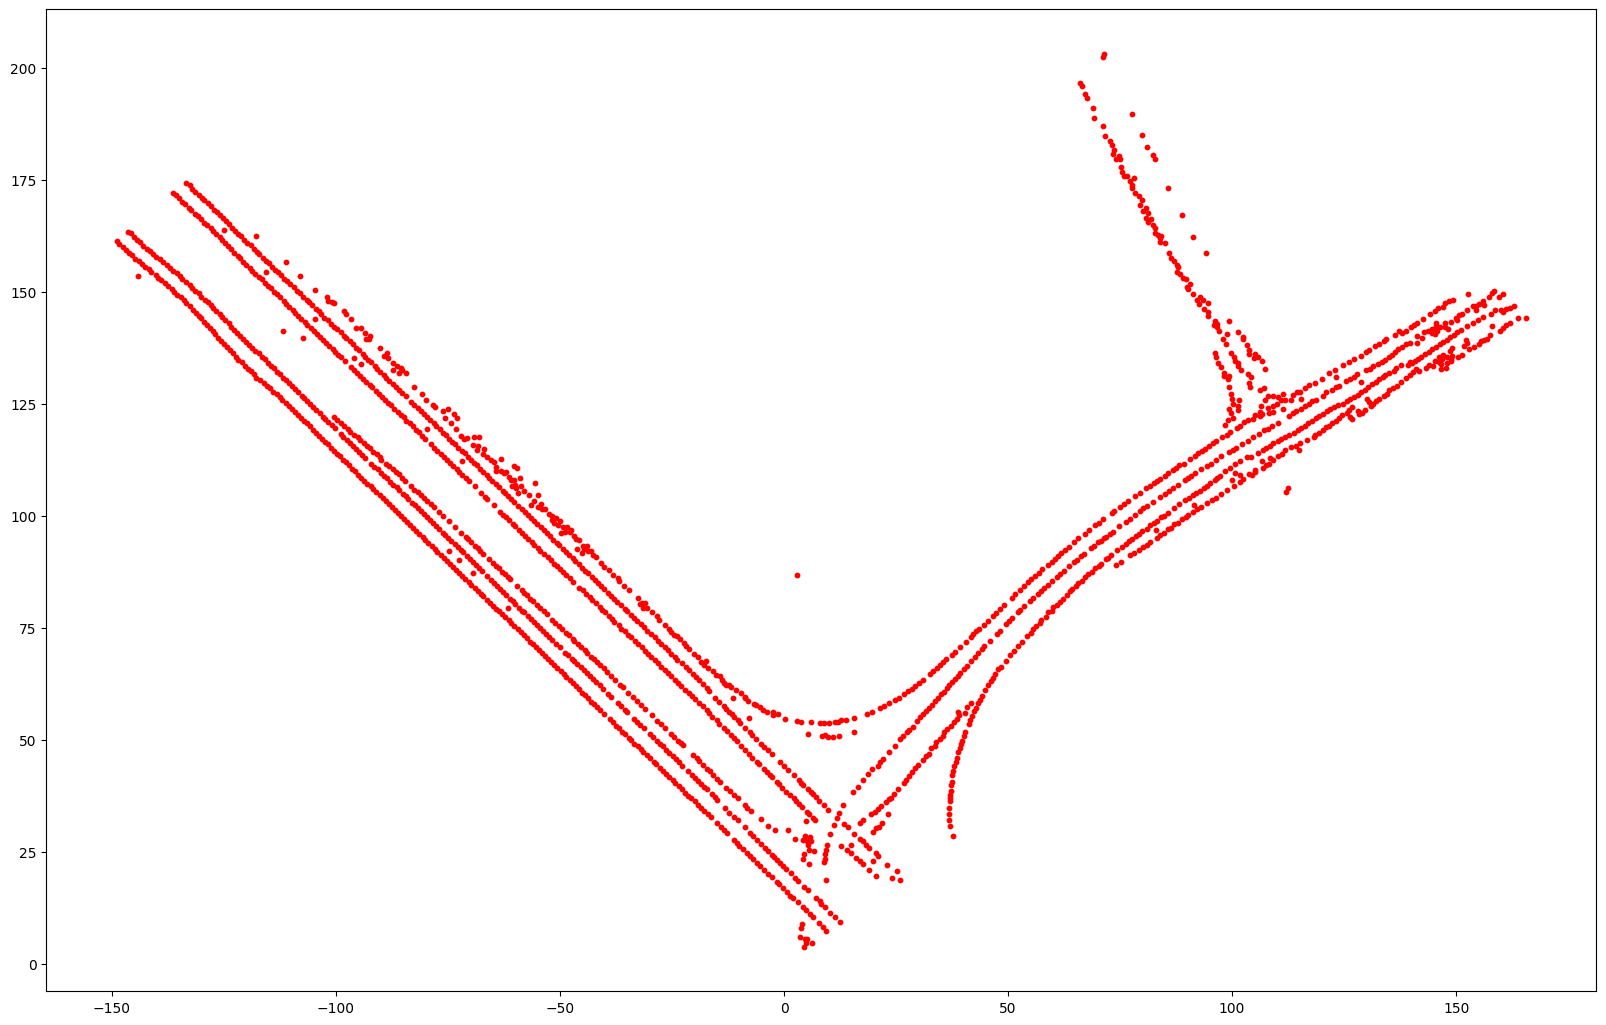

In [11]:
ld = ld.find_peaks(min_distance=3, threshold_quantile=0.9)

fig, ax = ld.plot_peaks()

# update the size of the figure
fig.set_size_inches(20, 20)

## Snap the Radar Data to the Grid

In [12]:
ld = (
    ld
    .snap_df_to_grid()
    .create_transition_df(
        valid_radius_m=10,
        filter_count_quantile=60,
    )
)

function: snap_df_to_grid took: 8.015082120895386 seconds
function: create_transition_df took: 2.103476047515869 seconds


## Make the Graph

function: _update_weights took: 0.04296398162841797 seconds
function: _add_distance took: 0.06011319160461426 seconds
function: drop_bidirectional_edges took: 0.008260965347290039 seconds
function: _make_angle_cache took: 0.13949108123779297 seconds
function: make_graph took: 0.280163049697876 seconds
function: plot_graph took: 2.7174389362335205 seconds


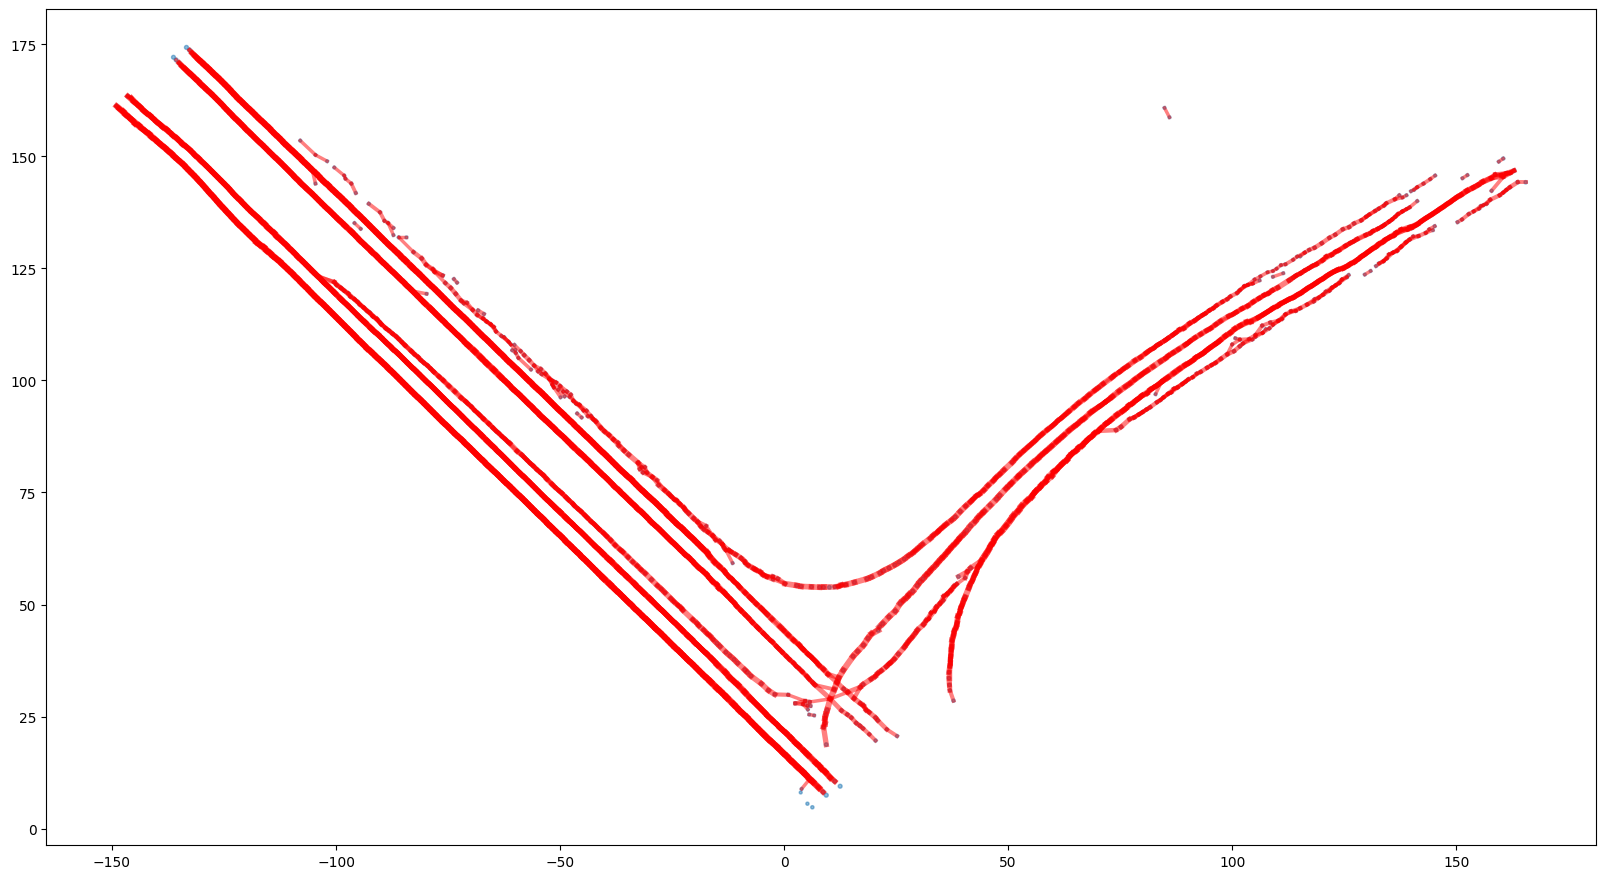

In [66]:
ld = ld.make_graph()

fig, ax = ld.plot_graph()

# update the size of the figure
fig.set_size_inches(20, 20)

### Cleanup the Graph

function: clean_graph_ins took: 0.008942127227783203 seconds
function: clean_graph_outs took: 0.00988912582397461 seconds
function: plot_graph took: 3.2217628955841064 seconds


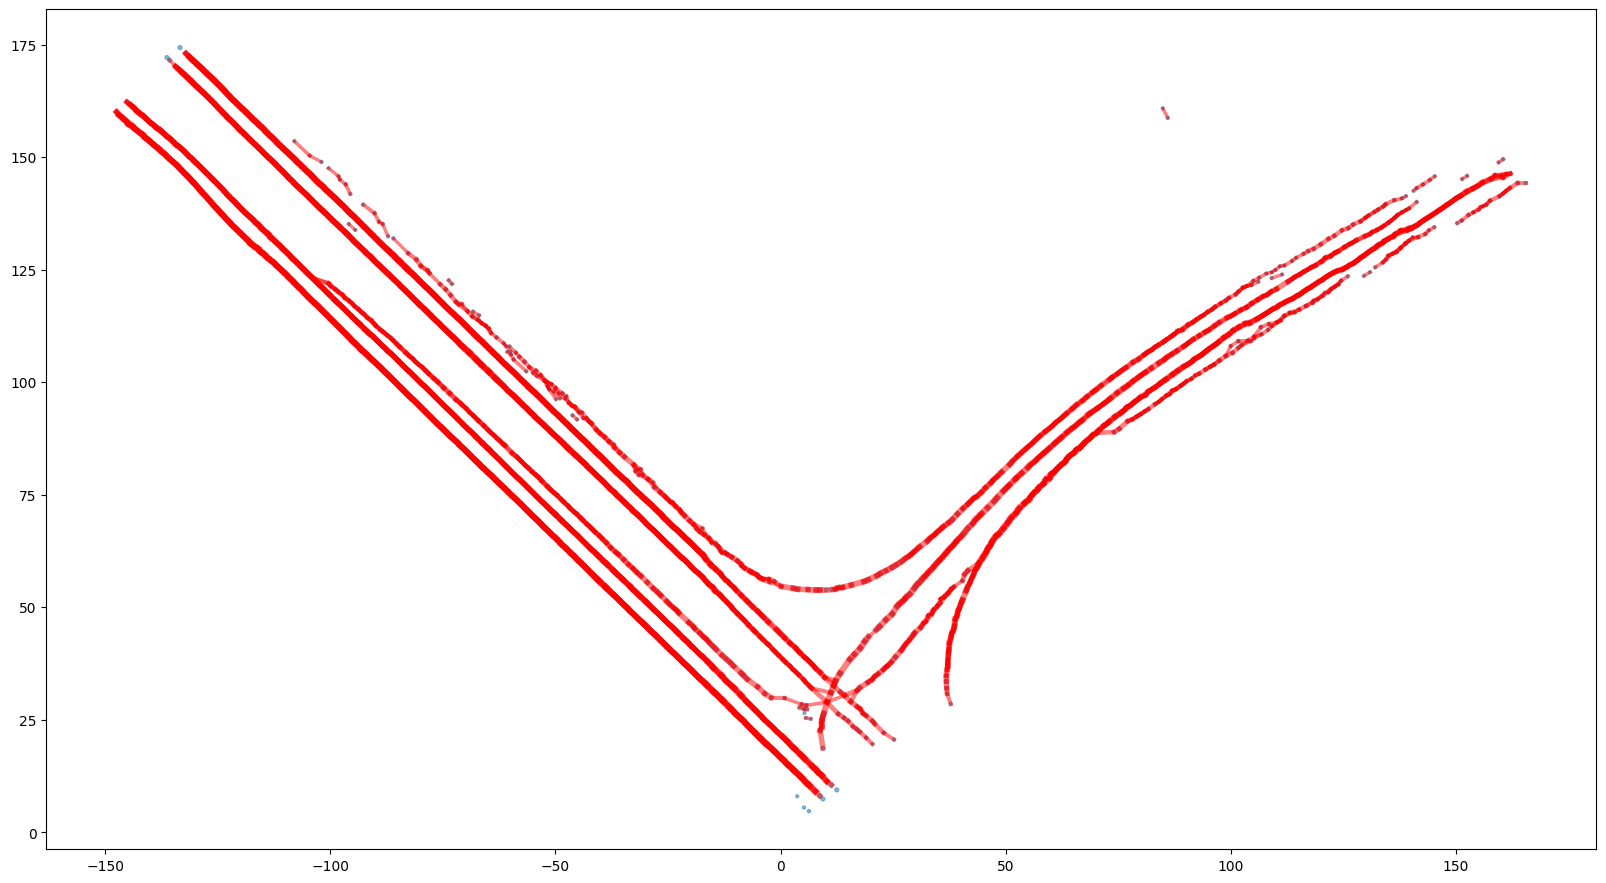

In [68]:
ld = ld.clean_graph_ins().clean_graph_outs()

fig, ax = ld.plot_graph()

# update the size of the figure
fig.set_size_inches(20, 20)

### Cleanup the Graph

function: drop_bidirectional_edges took: 0.007254123687744141 seconds
function: clean_graph_ins took: 0.003997087478637695 seconds
function: clean_graph_outs took: 0.003877878189086914 seconds
function: clean_subgraphs took: 0.08491802215576172 seconds
function: clean_isolated_nodes took: 0.0016210079193115234 seconds
function: plot_graph took: 2.7728731632232666 seconds


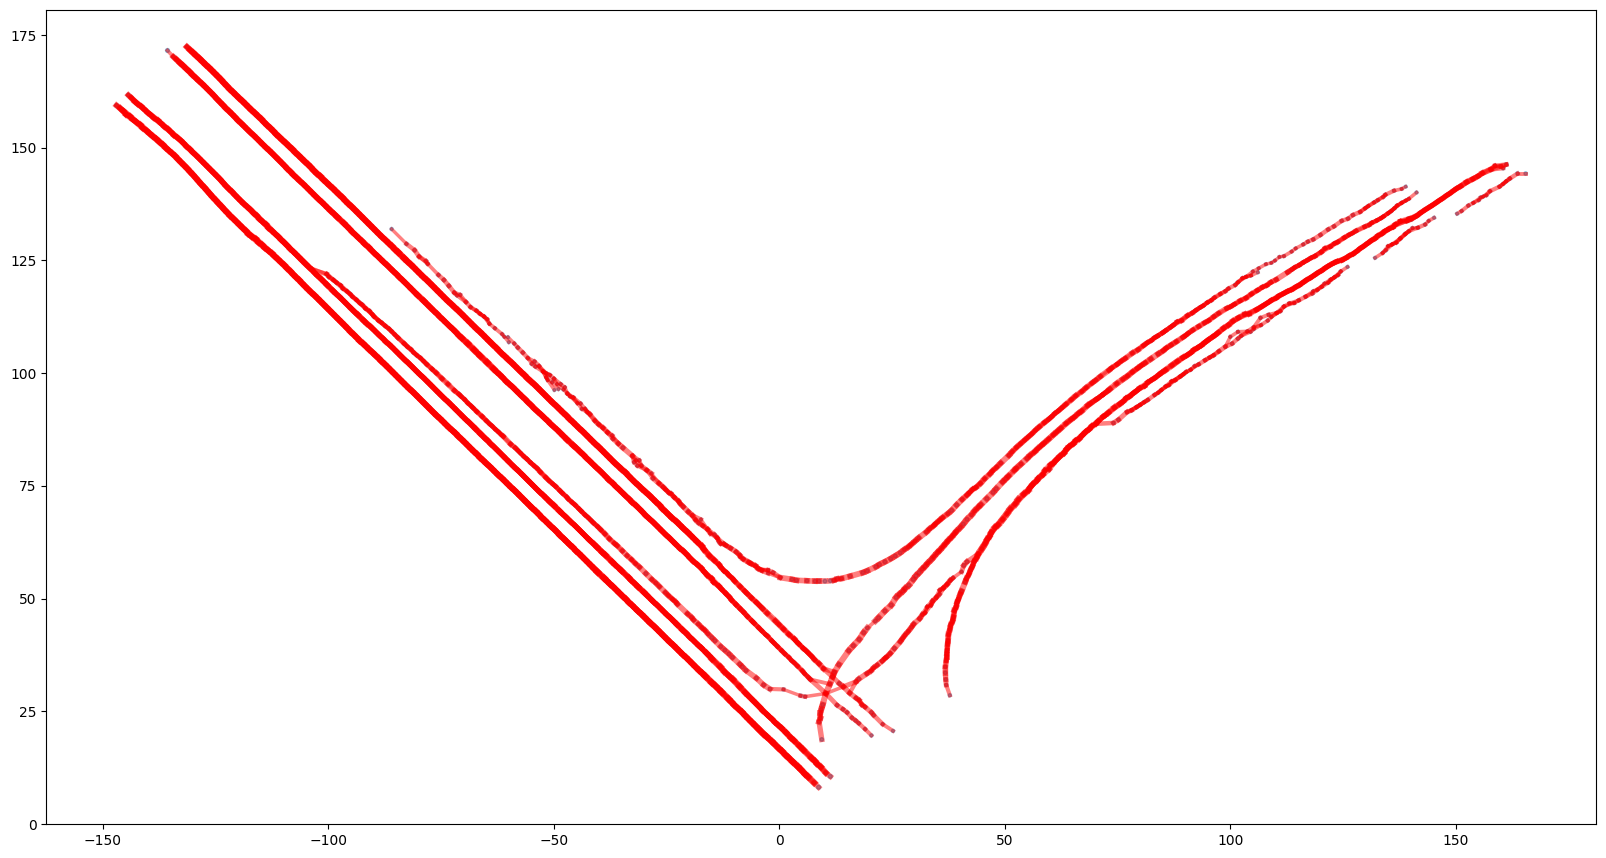

In [69]:
ld = (
    ld
    .drop_bidirectional_edges()
    .clean_graph_ins()
    .clean_graph_outs()
    .clean_subgraphs()
    .clean_isolated_nodes()
)

fig, ax = ld.plot_graph()

# update the size of the figure
fig.set_size_inches(20, 20)

### Find the Routes/Lanes

In [75]:
ld = ld.get_birth_nodes().get_death_nodes()
routes = ld.create_routes()

function: get_birth_nodes took: 0.0035991668701171875 seconds
function: get_death_nodes took: 0.002981901168823242 seconds
function: create_routes took: 0.16895389556884766 seconds


#### Split Routes into Non-Overlapping Segments

In [82]:
new_routes = ld.consolidate_routes(routes, min_route_length_m=5)

function: consolidate_routes took: 0.036828041076660156 seconds


function: plot_graph took: 2.9195809364318848 seconds
function: plot_routes took: 0.652259111404419 seconds


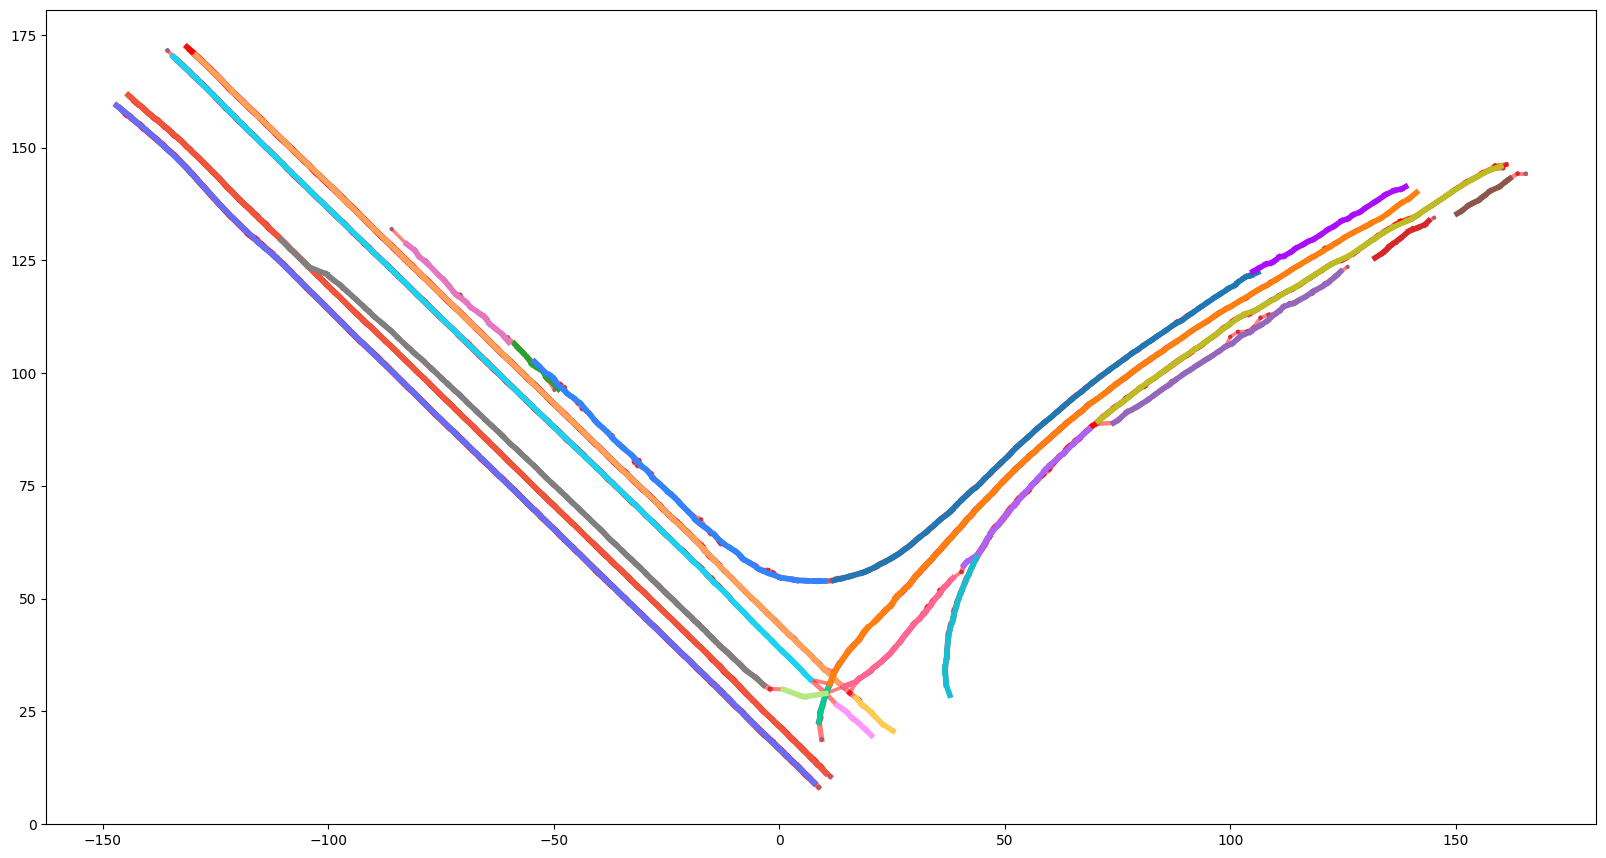

In [83]:
import plotly.express as px

fig, ax = ld.plot_graph()
fig, ax = ld.plot_routes(new_routes, ax=ax, color_scale=(px.colors.qualitative.Plotly + px.colors.qualitative.D3 + px.colors.qualitative.Alphabet + px.colors.qualitative.Dark24))

# update the size of the figure
fig.set_size_inches(20, 20)